In [63]:
import base64
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from PIL import Image
from pyproj import Transformer
from rasterio.windows import from_bounds


In [64]:
coords = [35.59570312500001,5.878332109674327,118.21289062500001,39.67337039176565]

## Window approach

In [75]:
min_lon, min_lat, max_lon, max_lat = coords

transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)

# Transform to EPSG:3857
min_x, min_y = transformer.transform(min_lon, min_lat)
max_x, max_y = transformer.transform(max_lon, max_lat)

with rasterio.open("sentinel_r10_cog.tif") as src:
    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    red = src.read(4, window=window)
    nir = src.read(5, window=window)

    ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
    ndvi = np.ma.masked_invalid(ndvi)

# Normalize NDVI values to 0-1 for color mapping
ndvi_normalized = (ndvi + 1) / 2
colormap = plt.get_cmap("RdYlGn")
ndvi_colored = colormap(ndvi_normalized)

ndvi_image = (ndvi_colored[:, :, :3] * 255).astype(np.uint8)
image = Image.fromarray(ndvi_image)

/tmp/ipykernel_73437/3918412899.py:14: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)


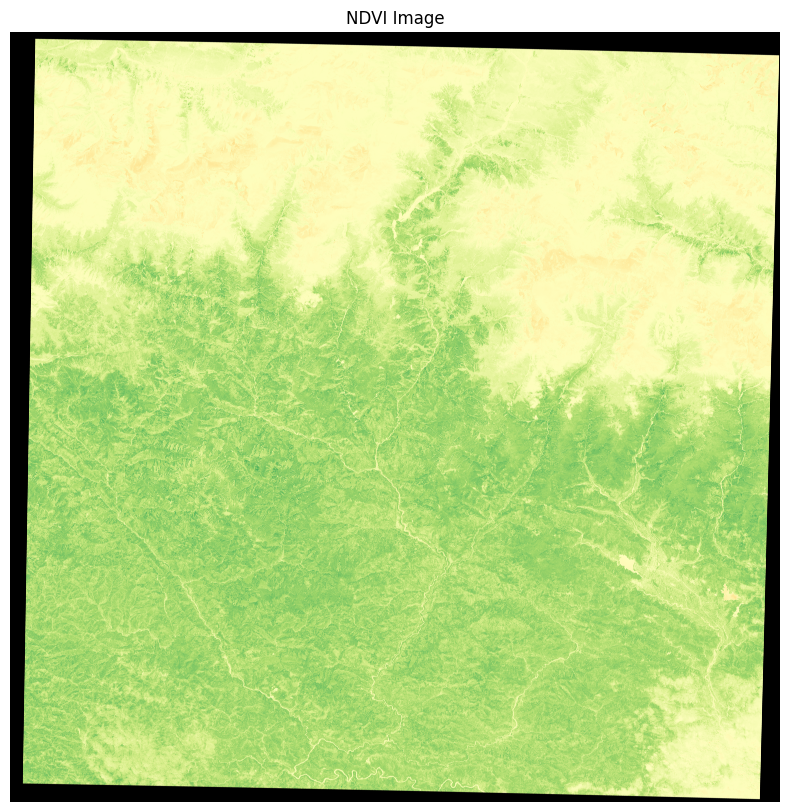

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('NDVI Image')
plt.axis('off')
plt.show()

In [68]:
with rasterio.open("sentinel_r10_4326_cog.tif") as src:
    print("Overviews:", src.overviews(1))  # Assuming band 1, change as needed
    print("Resolutions:", [src.res[0] / ov for ov in src.overviews(1)])

Overviews: [2, 4, 8, 16, 32, 64]
Resolutions: [4.777314267823516, 2.388657133911758, 1.194328566955879, 0.5971642834779395, 0.29858214173896974, 0.14929107086948487]


## Overview approach 

Still misses correct tiles 

In [92]:
def get_overview_level(src, band, desired_zoom_level):
    base_res = src.res[0] 
    
    overviews = src.overviews(band)
    desired_res = base_res / (2 ** desired_zoom_level)
    print("Desired resolution:", desired_res)
    
    overview_level = None
    for i, ov in enumerate(overviews):
        overview_res = base_res / ov
        if overview_res <= desired_res:
            overview_level = i
            break

    if overview_level is None:
        overview_level = len(overviews) - 1  # use highest if none match
    return overview_level

In [93]:
with rasterio.open("sentinel_r10_cog.tif") as src:
    print("Available Overviews for Band 1:", src.overviews(1))  # Replace 1 with the band number you need
    print("Base Resolution:", src.res)
    for i, ov in enumerate(src.overviews(1)):
        print(f"Overview {i}: Resolution {src.res[0] / ov}, {src.res[1] / ov}")
    print(get_overview_level(src,1,10))

Available Overviews for Band 1: [2, 4, 8, 16, 32, 64]
Base Resolution: (9.554628535647032, 9.554628535647032)
Overview 0: Resolution 4.777314267823516, 4.777314267823516
Overview 1: Resolution 2.388657133911758, 2.388657133911758
Overview 2: Resolution 1.194328566955879, 1.194328566955879
Overview 3: Resolution 0.5971642834779395, 0.5971642834779395
Overview 4: Resolution 0.29858214173896974, 0.29858214173896974
Overview 5: Resolution 0.14929107086948487, 0.14929107086948487
Desired resolution: 0.009330691929342804
5


In [102]:
lat, lon =  83.96851, 28.26689
zoom_level = 10

In [103]:
import mercantile 
from rasterio.windows import Window
tile = mercantile.tile(lon, lat, zoom_level)

In [96]:
print(tile)

Tile(x=750, y=428, z=10)


## Individual tile approach

In [109]:
def read_tile_from_cog(cog_path, tile, zoom, tile_size=256):
    with rasterio.open(cog_path) as src:
        
        # get pixel coords
        x_pixel = tile.x * tile_size
        y_pixel = tile.y * tile_size
        
        
        window = Window(x_pixel, y_pixel, tile_size, tile_size)
        print(window)
        
        red = src.read(4, window=window, resampling=rasterio.enums.Resampling.nearest)
        nir = src.read(5, window=window, resampling=rasterio.enums.Resampling.nearest)
        
        return red, nir

In [110]:
cog_path = "sentinel_r10_cog.tif"
red, nir = read_tile_from_cog(cog_path, tile, zoom_level)
print(f"Red band shape: {red.shape}, NIR band shape: {nir.shape}")

Window(col_off=151552, row_off=8192, width=256, height=256)
Red band shape: (256, 0), NIR band shape: (256, 0)


/tmp/ipykernel_73437/3107404338.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(red, cmap='Reds')
/tmp/ipykernel_73437/3107404338.py:10: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(nir, cmap='Greys')


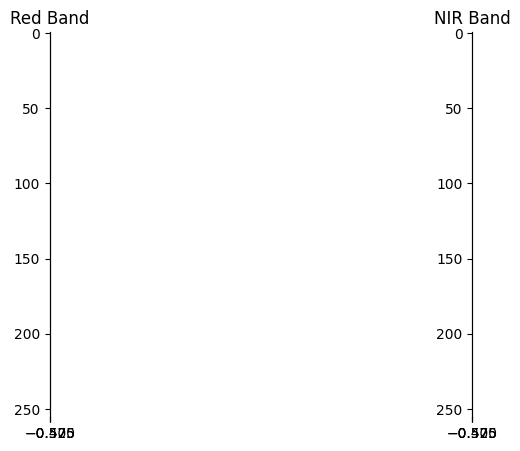

In [112]:
# plot red
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(red, cmap='Reds')
plt.title('Red Band')
# plt.colorbar()

# plot nir
plt.subplot(1, 2, 2)
plt.imshow(nir, cmap='Greys')
plt.title('NIR Band')
# plt.colorbar()

# show
plt.show()

In [106]:
def calculate_ndvi(red, nir):
    ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
    ndvi = np.ma.masked_invalid(ndvi)  # Mask invalid values
    return ndvi

ndvi = calculate_ndvi(red, nir)

## Rio - Tiler Approach

In [201]:
import mercantile
from rio_tiler.io import COGReader

In [238]:
lat, lon =28.202082, 83.987222
zoom_level = 12
tile = mercantile.tile(lon, lat, zoom_level)
print(tile)
tile_bounds = mercantile.bounds(tile)
print(tile_bounds)

Tile(x=3003, y=1713, z=12)
LngLatBbox(west=83.935546875, south=28.149503211544573, east=84.0234375, north=28.22697003891833)


In [239]:
cog_path = "sentinel_r10_cog.tif"

In [240]:
with COGReader(cog_path) as cog:
    print(cog.crs)
    print(cog.bounds)
    print(cog.minzoom)
    print(cog.maxzoom)
    print(cog.tms)
    tile_data,mask = cog.tile(tile.x,tile.y, zoom_level)
    print(tile_data.shape)
    

EPSG:3857
(9240930.97156467, 3236038.029481221, 9370568.171536328, 3365675.22945288)
8
14
title='Google Maps Compatible for the World' description=None keywords=None id='WebMercatorQuad' uri='http://www.opengis.net/def/tilematrixset/OGC/1.0/WebMercatorQuad' orderedAxes=['X', 'Y'] crs=CRS(root='http://www.opengis.net/def/crs/EPSG/0/3857') wellKnownScaleSet=AnyHttpUrl('http://www.opengis.net/def/wkss/OGC/1.0/GoogleMapsCompatible') boundingBox=None tileMatrices=[TileMatrix(title=None, description=None, keywords=None, id='0', scaleDenominator=559082264.028717, cellSize=156543.033928041, cornerOfOrigin='topLeft', pointOfOrigin=(-20037508.342789244, 20037508.342789244), tileWidth=256, tileHeight=256, matrixWidth=1, matrixHeight=1, variableMatrixWidths=None), TileMatrix(title=None, description=None, keywords=None, id='1', scaleDenominator=279541132.014358, cellSize=78271.5169640204, cornerOfOrigin='topLeft', pointOfOrigin=(-20037508.342789244, 20037508.342789244), tileWidth=256, tileHeight=25

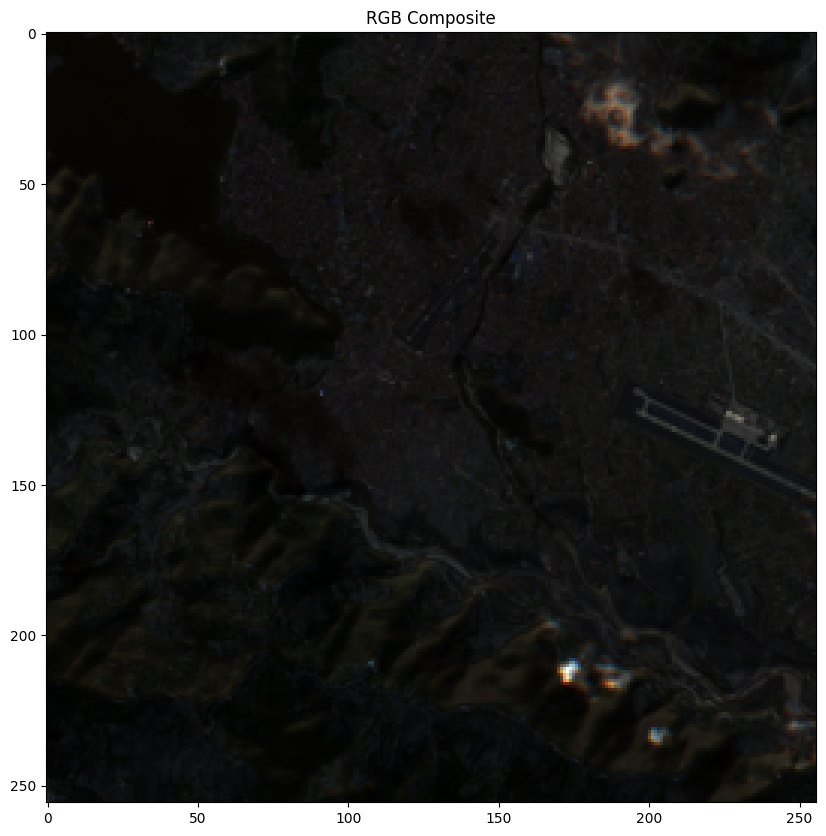

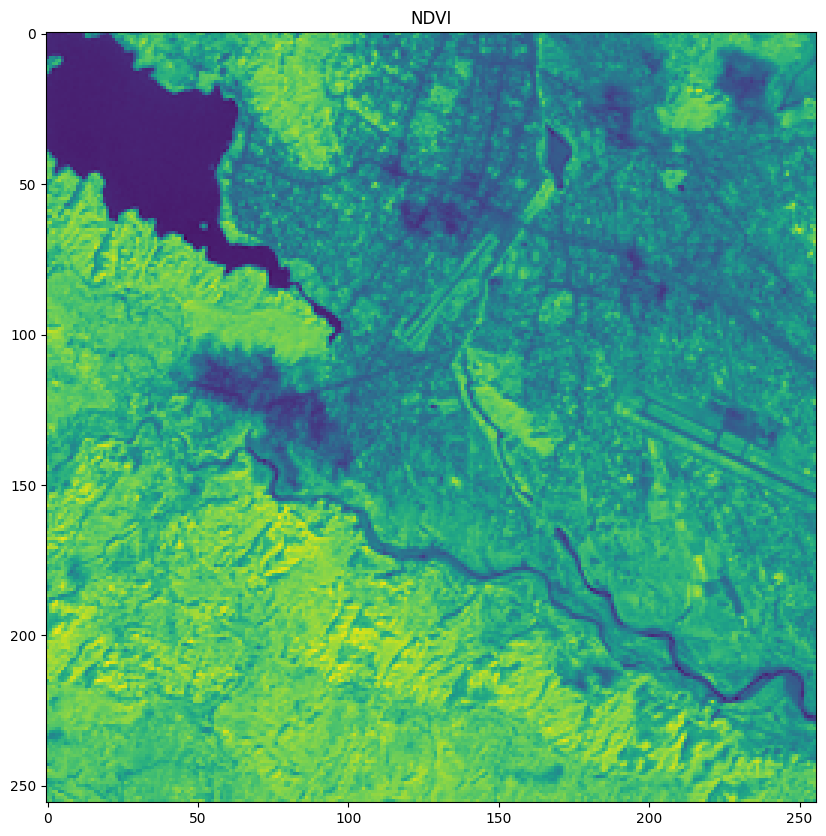

In [241]:

r = tile_data[1]
g = tile_data[2]
b = tile_data[3]
nir = tile_data[4]
# Normalize the 16-bit data to the [0, 1] range for visualization
r_norm = (r - np.min(r)) / (np.max(r) - np.min(r))
g_norm = (g - np.min(g)) / (np.max(g) - np.min(g))
b_norm = (b - np.min(b)) / (np.max(b) - np.min(b))


ndvi = (nir.astype(float) - r.astype(float)) / (nir + r)
ndvi = np.ma.masked_invalid(ndvi)
ndvi_normalized = (ndvi + 1) / 2

rgb = np.stack((r_norm, g_norm, b_norm), axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('RGB Composite')
plt.show()


plt.figure(figsize=(10, 10))
plt.imshow(ndvi_normalized)
plt.title('NDVI')
plt.show()

In [223]:
import requests

# Define the STAC API endpoint
stac_api_url = "https://earth-search.aws.element84.com/v0/search"

# Define the search parameters
search_params = {
    "collections": ["sentinel-s2-l2a-cogs"],
    "datetime": "2023-01-01T00:00:00Z/2023-12-31T23:59:59Z",
    "bbox": [12.4924, 41.8902, 12.4925, 41.8903],  # Example bounding box (Rome, Italy)
    "limit": 10
}

# Perform the search
response = requests.post(stac_api_url, json=search_params)
results = response.json()

# Print URLs of the COGs
for feature in results["features"]:
    print(feature["assets"]["B01"]["href"])  # Example accessing the B01 band URL

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/T/QM/2023/5/S2B_32TQM_20230505_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/T/QM/2023/4/S2A_32TQM_20230430_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/T/QM/2023/4/S2A_32TQM_20230420_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/T/TG/2023/4/S2A_33TTG_20230420_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/T/TG/2023/4/S2B_33TTG_20230415_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/T/QM/2023/4/S2B_32TQM_20230415_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/T/TG/2023/4/S2A_33TTG_20230410_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/T/QM/2023/4/S2A_32TQM_20230410_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentine

In [1]:
import time
from io import BytesIO
import requests
import os
import mercantile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from rio_tiler.io import COGReader
from concurrent.futures import ThreadPoolExecutor, as_completed

In [11]:
lat, lon = 28.202082, 83.987222
zoom_level = 12
tile = mercantile.tile(lon, lat, zoom_level)
bbox = mercantile.bounds(tile)

start_date = "2023-01-01"
end_date = "2023-12-31"
cloud_cover = 20 

STAC_API_URL = "https://earth-search.aws.element84.com/v0/search"

# Search parameters
search_params = {
    "collections": ["sentinel-s2-l2a-cogs"],
    "datetime": f"{start_date}T00:00:00Z/{end_date}T23:59:59Z",
    "query": {"eo:cloud_cover": {"lt": cloud_cover}},
    "bbox": [bbox.west, bbox.south, bbox.east, bbox.north],
    "limit": 100
}

In [12]:
def fetch_and_process_tile(red_url, nir_url, tile_x, tile_y, zoom_level):
    try:
        with COGReader(red_url) as red_cog, COGReader(nir_url) as nir_cog:
            red_tile, _ = red_cog.tile(tile_x, tile_y, zoom_level)
            nir_tile, _ = nir_cog.tile(tile_x, tile_y, zoom_level)

            r = red_tile[0]
            nir = nir_tile[0]

            ndvi = (nir.astype(float) - r.astype(float)) / (nir + r)
            ndvi = np.ma.masked_invalid(ndvi)

            return ndvi
    except Exception as e:
        print(f"Error fetching tile: {e}")
        return None

In [13]:
response = requests.post(STAC_API_URL, json=search_params)
if response.status_code != 200:
    raise Exception("Error searching STAC API")

results = response.json()
red_band_urls = [feature["assets"]["B04"]["href"] for feature in results["features"]]
nir_band_urls = [feature["assets"]["B08"]["href"] for feature in results["features"]]

print(f"Processing {len(red_band_urls)} images...using {os.cpu_count()} cores")


Processing 26 images...using 32 cores


Processing tiles : Batch 0:   4%|▍         | 1/26 [02:41<1:07:23, 161.75s/it]/tmp/ipykernel_308243/4147265488.py:10: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir.astype(float) - r.astype(float)) / (nir + r)
Processing tiles : Batch 0: 100%|██████████| 26/26 [02:45<00:00,  6.37s/it]  


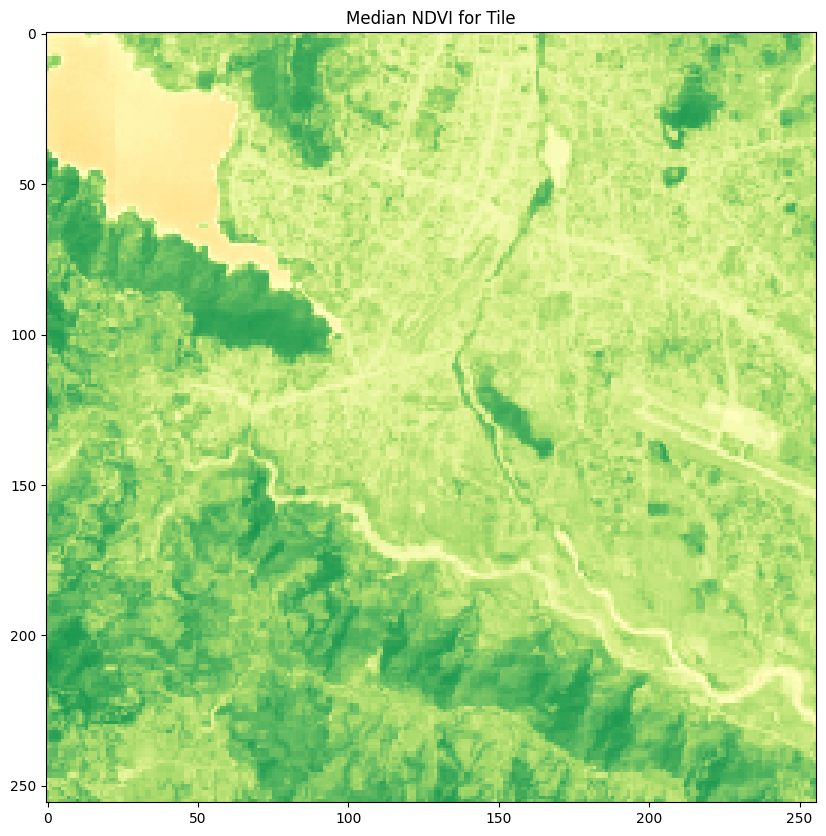

In [14]:
num_cores = os.cpu_count()
max_workers = max(1, num_cores - 2) # Leave 2 cores for other processes
ndvi_list = []
# Batch processing
batch_size = max(10, max_workers)
for i in range(0, len(red_band_urls), batch_size):
    batch_red_urls = red_band_urls[i:i + batch_size]
    batch_nir_urls = nir_band_urls[i:i + batch_size]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(fetch_and_process_tile, red_url, nir_url, tile.x, tile.y, zoom_level)
            for red_url, nir_url in zip(batch_red_urls, batch_nir_urls)
        ]

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing tiles : Batch {i}"):
            ndvi = future.result()
            if ndvi is not None:
                ndvi_list.append(ndvi)

if ndvi_list:
    ndvi_stack = np.ma.stack(ndvi_list)
    ndvi_median = np.ma.median(ndvi_stack, axis=0)
    ndvi_normalized = (ndvi_median + 1) / 2

    colormap = plt.get_cmap("RdYlGn")
    ndvi_colored = colormap(ndvi_normalized)

    ndvi_image = (ndvi_colored[:, :, :3] * 255).astype(np.uint8)
    image = Image.fromarray(ndvi_image)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Median NDVI for Tile")
    plt.show()
else:
    print("No images found for the given parameters")

## Window approach with cog over time

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from PIL import Image
from rasterio.windows import from_bounds
import requests
import mercantile
import os 
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from pyproj import Transformer
from shapely.geometry import shape, box
lat, lon = 28.28139,83.91866
zoom_level = 12
tile = mercantile.tile(lon, lat, zoom_level)
bbox = mercantile.bounds(tile)
print(bbox)
bbox_polygon = box(bbox.west, bbox.south, bbox.east, bbox.north)

start_date = "2023-01-01"
end_date = "2023-12-31"
cloud_cover = 20 

STAC_API_URL = "https://earth-search.aws.element84.com/v1/search"

# Search parameters
search_params = {
    "collections": ["sentinel-2-l2a"],
    "datetime": f"{start_date}T00:00:00Z/{end_date}T23:59:59Z",
    "query": {"eo:cloud_cover": {"lt": cloud_cover}},
    "bbox": [bbox.west, bbox.south, bbox.east, bbox.north],
    "limit": 100
}

response = requests.post(STAC_API_URL, json=search_params)
if response.status_code != 200:
    raise Exception("Error searching STAC API")

results = response.json()
print(f"Found {len(results['features'])} items")



# Filter features that are completely within the bounding box
filtered_features = [
    feature for feature in results['features']
    if shape(feature['geometry']).contains(bbox_polygon)
]

# Get the red and NIR band URLs for the filtered features
red_band_urls = [feature["assets"]["red"]["href"] for feature in filtered_features]
nir_band_urls = [feature["assets"]["nir"]["href"] for feature in filtered_features]

visual_band_urls = [feature["assets"]["visual"]["href"] for feature in filtered_features]

print(f"Filtered {len(filtered_features)} items that are completely within the input bounding box")



LngLatBbox(west=83.84765625, south=28.22697003891833, east=83.935546875, north=28.304380682962773)
Found 27 items
Filtered 27 items that are completely within the input bounding box


In [17]:
def fetch_and_process_window(red_url, nir_url):
    try:

        with rasterio.open(red_url) as red_cog, rasterio.open(nir_url) as nir_cog:

            transformer = Transformer.from_crs("epsg:4326", red_cog.crs, always_xy=True)

            min_x, min_y = transformer.transform(bbox.west, bbox.south)
            max_x, max_y = transformer.transform(bbox.east,  bbox.north)

            red_window = from_bounds(min_x, min_y, max_x, max_y, red_cog.transform)
            nir_window = from_bounds(min_x, min_y, max_x, max_y, nir_cog.transform)

            if red_window.col_off < 0 or red_window.row_off < 0 or \
               red_window.width <= 0 or red_window.height <= 0 or \
               nir_window.col_off < 0 or nir_window.row_off < 0 or \
               nir_window.width <= 0 or nir_window.height <= 0:
                print("Calculated window is out of bounds.")
                return None

            red = red_cog.read(1, window=red_window)
            nir = nir_cog.read(1, window=nir_window)

            red = red.astype(float)
            nir = nir.astype(float)

            ndvi = (nir - red) / (nir + red)

            ndvi = np.ma.masked_invalid(ndvi)

            return ndvi
    except Exception as e:
        print(f"Error fetching image: {e}")
        # raise e
        return None


def fetch_and_process_window_visual(visual_url):
    try:
        with rasterio.open(visual_url) as visual_cog:
            print(visual_url)

            transformer = Transformer.from_crs("epsg:4326", visual_cog.crs, always_xy=True)

            min_x, min_y = transformer.transform(bbox.west, bbox.south)
            max_x, max_y = transformer.transform(bbox.east, bbox.north)

            visual_cog_window = from_bounds(min_x, min_y, max_x, max_y, visual_cog.transform)

            if visual_cog_window.col_off < 0 or visual_cog_window.row_off < 0 or \
               visual_cog_window.width <= 0 or visual_cog_window.height <= 0:
                print("Calculated window is out of bounds.")
                return None

            image = visual_cog.read([1, 2, 3], window=visual_cog_window)

            parts = visual_url.split('/')
            image_name=parts[-2]
            output_file = f"static/{image_name}_rgb.tif"

            with rasterio.open(
                output_file,
                'w',
                driver='GTiff',
                height=image.shape[1],
                width=image.shape[2],
                count=3,
                dtype=image.dtype,
                crs=visual_cog.crs,
                transform=visual_cog.window_transform(visual_cog_window)
            ) as dst:
                dst.write(image[0], 1)  # Red band
                dst.write(image[1], 2)  # Green band
                dst.write(image[2], 3)  # Blue band

            print(f"Saved image to {output_file}")
            return output_file , image_name
    except Exception as e:
        print(f"Error fetching image: {e}")
        raise e
        return None







0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


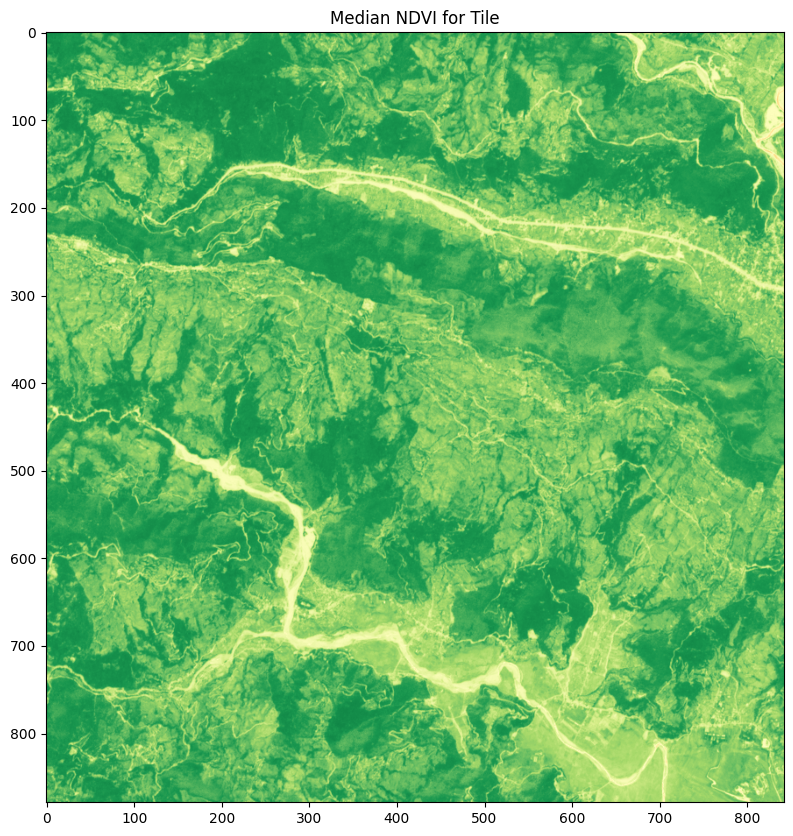

In [19]:
ndvi_list = []

for red_url, nir_url in zip(red_band_urls, nir_band_urls):
    print(len(ndvi_list))
    ndvi = fetch_and_process_window(red_url, nir_url)
    if ndvi is not None:
        ndvi_list.append(ndvi)
    
if ndvi_list:
    ndvi_stack = np.ma.stack(ndvi_list)
    ndvi_median = np.ma.median(ndvi_stack, axis=0)
    ndvi_normalized = (ndvi_median + 1) / 2

    colormap = plt.get_cmap("RdYlGn")
    ndvi_colored = colormap(ndvi_normalized)

    ndvi_image = (ndvi_colored[:, :, :3] * 255).astype(np.uint8)
    image = Image.fromarray(ndvi_image)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Median NDVI for Tile")
    plt.show()
else:
    print("No images found for the given parameters")


In [15]:
import imageio
def add_text_to_image(image_path, text):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.text(10, 10, text, color='white', fontsize=12, backgroundcolor='black')
    temp_image_path = os.path.splitext(image_path)[0] + "_text.png"
    plt.savefig(temp_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    return temp_image_path

def create_gif(image_list, output_path, duration=0.5):
    images = [imageio.imread(image_path) for image_path in image_list]
    imageio.mimsave(output_path, images, duration=duration)
    print(f"Saved GIF to {output_path}")


In [18]:
image_list = []

for band_url in visual_band_urls:
    image_path, image_name = fetch_and_process_window_visual(band_url)
    if image_path is not None:
        image_with_text = add_text_to_image(image_path, image_name)
        image_list.append(image_with_text)

if image_list:
    # plot_gif(image_list)
    create_gif(image_list, "output.gif")
else:
    print("No images found for the given parameters")

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/44/R/QS/2023/12/S2B_44RQS_20231231_0_L2A/TCI.tif
Saved image to static/S2B_44RQS_20231231_0_L2A_rgb.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/44/R/QS/2023/12/S2A_44RQS_20231226_0_L2A/TCI.tif
Saved image to static/S2A_44RQS_20231226_0_L2A_rgb.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/44/R/QS/2023/12/S2B_44RQS_20231221_0_L2A/TCI.tif
Saved image to static/S2B_44RQS_20231221_0_L2A_rgb.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/44/R/QS/2023/12/S2A_44RQS_20231216_0_L2A/TCI.tif
Saved image to static/S2A_44RQS_20231216_0_L2A_rgb.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/44/R/QS/2023/12/S2B_44RQS_20231211_0_L2A/TCI.tif
Saved image to static/S2B_44RQS_20231211_0_L2A_rgb.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/44/R/QS/2023/12/S2A_44RQS_20231206_0_L2A/TCI.tif
Saved image

/tmp/ipykernel_199344/1537039988.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(image_path) for image_path in image_list]


Saved GIF to output.gif


In [ ]:
from src.vcube.engine import VCubeProcessor

# Define the bounding box
bbox = [83.84765625, 28.22697003891833, 83.935546875, 28.304380682962773]

# Define the parameters
start_date = "2024-12-15"
end_date = "2024-12-31"
cloud_cover = 30
formula = "band1"  # NDVI formula
band1 = "visual" 
band2 = None
operation = "median"
output_dir = "output"
timeseries = True

processor = VCubeProcessor(
    bbox,
    start_date,
    end_date,
    cloud_cover,
    formula,
    band1,
    band2,
    operation,
    timeseries,
    output_dir,
)
processor.compute()

Engine starting...
Searching STAC API...
Filtered 4 items that are completely within the input bounding box
Computing Band Calculation: 100%|██████████| 4/4 [00:20<00:00,  5.02s/it]
Aggregating results...
Saving aggregated result with colormap...
Creating GIF and zipping TIFF files...
Saved GIF to output/output.gif
Saved ZIP to output/tiff_files.zip
